# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

sns.set_palette("husl")

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

# config python file
import config


# 再現性をもたせるためのseed固定
SEED = config.SEED

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


fix_seed(SEED)

# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [3]:
X = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X.pkl")
y = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y.pkl")


X_train_std = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train_std.pkl"
)
X_test_std = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test_std.pkl"
)
X_train_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train_norm.pkl"
)
X_test_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test_norm.pkl"
)
y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_test.pkl"
)

In [4]:
X_train_std.shape, X_test_std.shape

((1187, 54), (396, 54))

# 学習データの分布をプロット

オーバーサンプリング手法がどのように目的変数を生成しているのかを可視化する。  
x,y軸には以下の２パターンを描画する  
1. 3.0.0のノートブックで実施した決定木で重要度の上位に位置した特徴量（["NPI", "THREEGENE_ER-/HER2-"]）
2. float型の特徴量の中で、値がそれなりに分布している特徴量（["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]）

## ツール
- seaborn-analyzer: https://github.com/c60evaporator/seaborn-analyzer

### スケーリング関数

In [5]:
# 標準化・正規化を行う関数
def transform_normalization(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    ss = StandardScaler()
    ss.fit(df)
    df = pd.DataFrame(
        ss.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df


def transform_minmaxscaler(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    mm = MinMaxScaler()
    mm.fit(df)
    df = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df

In [6]:
# 標準化を行う関数
def transform_std(X_train: pd.DataFrame(), X_test: pd.DataFrame() = None):
    std = StandardScaler()
    std.fit(X_train)
    X_train_std = pd.DataFrame(
        std.transform(X_train),
        index=X_train.index,
        columns=X_train.columns,
    )
    if X_test is None:
        return X_train_std
    X_test_std = pd.DataFrame(
        std.transform(X_test),
        index=X_test.index,
        columns=X_test.columns,
    )
    return X_train_std, X_test_std


# 正規化を行う関数
def transform_norm(
    X_train: pd.DataFrame(), X_test: pd.DataFrame() = None
) -> pd.DataFrame():
    mm = MinMaxScaler()
    mm.fit(X_train)
    X_train_norm = pd.DataFrame(
        mm.transform(X_train),
        index=X_train.index,
        columns=X_train.columns,
    )
    if X_test is None:
        return X_train_norm
    X_test_norm = pd.DataFrame(
        mm.transform(X_test),
        index=X_test.index,
        columns=X_test.columns,
    )
    return X_train_norm, X_test_norm

### 可視化関数

In [7]:
# 散布図のプロット。targetの分類や、plot_columnsに沿った分布の様子も表記
def sns_join_plot(
    X: pd.DataFrame(),  # 2次元のdf。縦軸・横軸に表示したい特徴量を持つ
    y: pd.Series(),  # 目的変数。色分けして表示する。
    plot_columns: list,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = X.copy()
    if normalization:
        df_tmp = transform_norm(X)

    sns.jointplot(
        x=plot_columns[0],
        y=plot_columns[1],
        data=df_tmp,
        hue=y,
    )
    plt.plot()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


"""
        
# モデルとその分類結果のプロットを実施（表示する都合上、2次元なため、あくまでなんとなくの分類境界をプロットする）。
# 範囲は基本[0,1]とし、複数モデルをプロットした際に比較しやすいようにする。空白部分はテストデータの範囲のせい。
def sns_separator_plot(
    clf,
    x_columns: list,
    y_column: str,
    X: pd.DataFrame,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data.copy()
    if normalization:
        df_tmp = transform_norm(data)

    classplot.class_separator_plot(
        clf=clf,
        x=x_columns,
        y=y_column,
        data=X,
        # plot_scatter="class_error",
        scatter_colors=["r", "b"],
        cv=10,
        cv_seed=SEED,
        true_marker="o",
        false_marker="x",
        subplot_kws={"figsize": (7, 7)},
    )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save_path:
        plt.savefig(save_path)
    else:
        plt.plot()
"""

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_62518/3873249386.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),  # 目的変数。色分けして表示する。


'\n        \n# モデルとその分類結果のプロットを実施（表示する都合上、2次元なため、あくまでなんとなくの分類境界をプロットする）。\n# 範囲は基本[0,1]とし、複数モデルをプロットした際に比較しやすいようにする。空白部分はテストデータの範囲のせい。\ndef sns_separator_plot(\n    clf,\n    x_columns: list,\n    y_column: str,\n    X: pd.DataFrame,\n    normalization: bool = True,\n    save_path: str = None,  # also need a file name\n):\n    df_tmp = data.copy()\n    if normalization:\n        df_tmp = transform_norm(data)\n\n    classplot.class_separator_plot(\n        clf=clf,\n        x=x_columns,\n        y=y_column,\n        data=X,\n        # plot_scatter="class_error",\n        scatter_colors=["r", "b"],\n        cv=10,\n        cv_seed=SEED,\n        true_marker="o",\n        false_marker="x",\n        subplot_kws={"figsize": (7, 7)},\n    )\n    plt.xlim([0, 1])\n    plt.ylim([0, 1])\n    if save_path:\n        plt.savefig(save_path)\n    else:\n        plt.plot()\n'

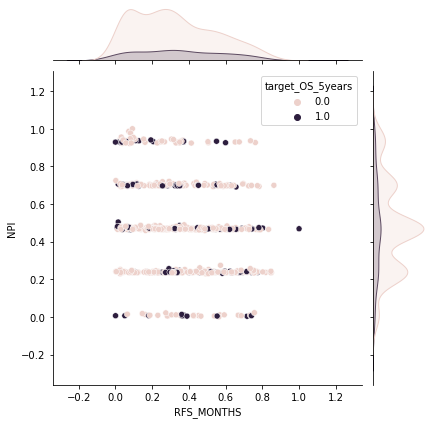

In [8]:
plot_columns = ["RFS_MONTHS", "NPI"]
# 目的変数の分布と２つの特徴量の可視化8
sns_join_plot(X_train_std, y_train, plot_columns, normalization=True)

# 2値分類モデル

### 評価の表示・可視化関数

In [9]:
# 基本的なスコアの表示（面倒なので関数化した）
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))


# 混合行列のプロット
def plot_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    325
True      71
Name: target_OS_5years, dtype: int64

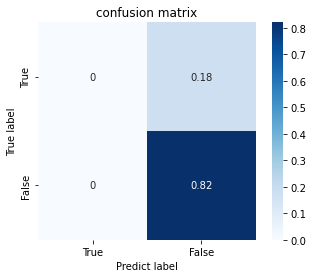

In [10]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
plot_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [11]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(max_iter=2000),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [12]:
def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    folds: int = 5,
    test_size: float = 0.25,
    over_sampling_class=None,
    normalization: bool = False,
    plot_cfmatrix=False,
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        print(name)  # モデル名
        # k分割交差検証の実施
        kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)
        for train_index, test_index in tqdm(kf.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            # print("initsize: ", X_train.shape)
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if normalization:
                # 正規化処理の実施（スケールを[0,1]に抑える）
                # 正規化を施すcolumnsの指定
                int_columns = [
                    # patient
                    "LYMPH_NODES_EXAMINED_POSITIVE",
                ]

                float_columns = [
                    # patient
                    "NPI",
                    "AGE_AT_DIAGNOSIS",
                    # sample
                    "TUMOR_SIZE",
                    "TMB_NONSYNONYMOUS",
                ]

                # trainデータにtestデータの内容を含ませないようにするため、MiMaxScaler()のsetを適用するのはtrainデータのみ
                mm = MinMaxScaler()
                mm.fit(X_train[int_columns + float_columns])
                X_train[int_columns + float_columns] = pd.DataFrame(
                    mm.transform(X_train[int_columns + float_columns]),
                    index=X_train[int_columns + float_columns].index,
                    columns=int_columns + float_columns,
                )

                X_test[int_columns + float_columns] = pd.DataFrame(
                    mm.transform(X_test[int_columns + float_columns]),
                    index=X_test[int_columns + float_columns].index,
                    columns=[int_columns + float_columns],
                )

            # オーバーサンプリング（trainデータのみに適用）
            if over_sampling_class:
                X_train, y_train = over_sampling_class.fit_resample(X_train, y_train)
            # print("over sampling size: ", X_train.shape)

            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納
        # 混合行列の表示
        if plot_cfmatrix:
            plot_confusion_matrix(y_test, y_pred)

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_62518/2893447028.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [13]:
import warnings


def plot_bcm_border(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    plot_columns: list = plot_columns,
    sort_column_name: str = "f1_test",
    over_sampling_class=None,
    normalization: bool = False,
    save_path: str = ".",
):

    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in tqdm(zip(bcm_names, classifiers)):  # 指定した複数の分類機を順番に呼び出す
        # init
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
        if normalization:
            # 正規化
            int_columns = [
                # patient
                "LYMPH_NODES_EXAMINED_POSITIVE",
            ]

            float_columns = [
                # patient
                "NPI",
                "AGE_AT_DIAGNOSIS",
                # sample
                "TUMOR_SIZE",
                "TMB_NONSYNONYMOUS",
            ]

            mm = MinMaxScaler()
            mm.fit(X_train[int_columns + float_columns])
            X_train[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_train[int_columns + float_columns]),
                index=X_train[int_columns + float_columns].index,
                columns=int_columns + float_columns,
            )
            X_test[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_test[int_columns + float_columns]),
                index=X_test[int_columns + float_columns].index,
                columns=int_columns + float_columns,
            )
        if over_sampling_class:
            X_train, y_train = over_sampling_class.fit_resample(X_train, y_train)

        # プロット
        print(name)  # モデル名
        make_dir(save_path)
        sns_separator_plot(
            clf=clf,
            x_columns=plot_columns,
            y_column="target_OS_5years",
            data=pd.merge(X_train, y_train, left_index=True, right_index=True),
            save_path=save_path + "/" + name + ".png",
        )
    warnings.filterwarnings("always")

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_62518/2059379517.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [14]:
# 2値分類機の性能比較（パラメータ：デフォルト）
display(
    compare_bcms(X=X_train_std, y=y_train, bcm_names=bcm_names, classifiers=classifiers)
)

display(
    compare_bcms(
        X=X_train_norm, y=y_train, bcm_names=bcm_names, classifiers=classifiers
    )
)

Logistic Regression


5it [00:00,  5.17it/s]


Nearest Neighbors


5it [00:00, 44.78it/s]


Linear SVM


5it [00:36,  7.32s/it]


Polynomial SVM


5it [00:00,  6.33it/s]


RBF SVM


5it [00:00, 16.42it/s]


Sigmoid SVM


5it [00:00, 30.37it/s]


Decision Tree


5it [00:00, 208.07it/s]


Random Forest


5it [00:00, 11.59it/s]


AdaBoost


5it [00:00, 16.76it/s]


Naive Bayes


5it [00:00, 272.78it/s]


Quadratic Discriminant Analysis


5it [00:00, 46.57it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.935989,1.000000,0.832161
Linear SVM,0.951560,0.926721,0.877620,0.816850
Logistic Regression,0.947768,0.924210,0.868165,0.806698
AdaBoost,0.972621,0.910708,0.931025,0.774904
Decision Tree,1.000000,0.907347,1.000000,0.765484
Naive Bayes,0.898905,0.887969,0.770499,0.743195
Quadratic Discriminant Analysis,0.789385,0.790217,0.649216,0.649333
Sigmoid SVM,0.705137,0.702610,0.192537,0.187605
Nearest Neighbors,0.824978,0.782622,0.286661,0.073277


Logistic Regression


5it [00:00, 11.43it/s]


Nearest Neighbors


5it [00:00, 58.19it/s]


Linear SVM


5it [01:18, 15.72s/it]


Polynomial SVM


5it [00:00,  6.00it/s]


RBF SVM


5it [00:00, 16.51it/s]


Sigmoid SVM


5it [00:00, 30.07it/s]


Decision Tree


5it [00:00, 214.19it/s]


Random Forest


5it [00:00, 11.60it/s]


AdaBoost


5it [00:00, 16.84it/s]


Naive Bayes


5it [00:00, 288.37it/s]


Quadratic Discriminant Analysis


5it [00:00, 41.98it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.930089,1.000000,0.815231
Decision Tree,1.000000,0.911559,1.000000,0.779665
Linear SVM,0.933658,0.914080,0.827546,0.777456
AdaBoost,0.972621,0.910708,0.931025,0.774904
Logistic Regression,0.930287,0.911548,0.814945,0.760101
Naive Bayes,0.894483,0.884597,0.763046,0.738380
Quadratic Discriminant Analysis,0.789385,0.790217,0.649216,0.649333
Sigmoid SVM,0.705137,0.702610,0.192537,0.187605
Nearest Neighbors,0.818449,0.768305,0.268151,0.049479


デフォルト値のままではf1スコアが出ない  
→全て負事例（0: 5年後も生存）で予測しているケースが多い（多少は正事例（1: 5年以内に死亡）としているケースもあるが）

2022/06/24.  
▷ 特徴量への処理を変更した（nullの少ないデータの削除、nullの多い特徴量の削除）ら精度が向上した

# 各モデルパラメータ調整等含む詳細な実験の実施

## ロジスティック回帰モデル

発生確率を予測する手法  
予測結果が0~1の間を取る  

In [15]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_std, y_train)
# テストデータでの正答率
clf_lr.score(X_test_std, y_test)

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9494949494949495

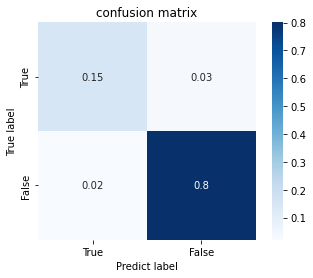

In [16]:
y_pred_lr = clf_lr.predict(X_test_std)
plot_confusion_matrix(y_test, y_pred_lr)

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [17]:
warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=nodes_num, random_state=SEED)
    clf_tree = clf_tree.fit(X_train_std, y_train)

    y_pred_tree = clf_tree.predict(X_test_std)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    # print("nodes_num: ", nodes_num)
    # show_scores(y_test, y_pred_tree)
    # print("----------" * 10)

warnings.filterwarnings("always")

accuracies_tree

'max nodes_num'

7

3

2

9

accuracy:  0.9444444444444444
precision:  0.7951807228915663
recall:  0.9295774647887324
f1_score:  0.8571428571428571


Text(0, 0.5, 'score')

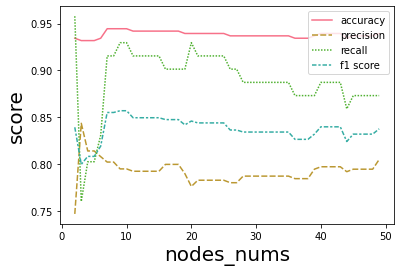

In [18]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルの各スコアの表示
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

# スコアの推移のプロット
df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

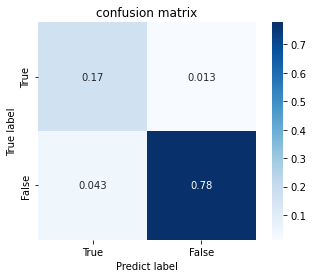

In [19]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_train_std, y_train)
y_pred_tree = clf_tree.predict(X_test_std)
plot_confusion_matrix(y_test, y_pred_tree)

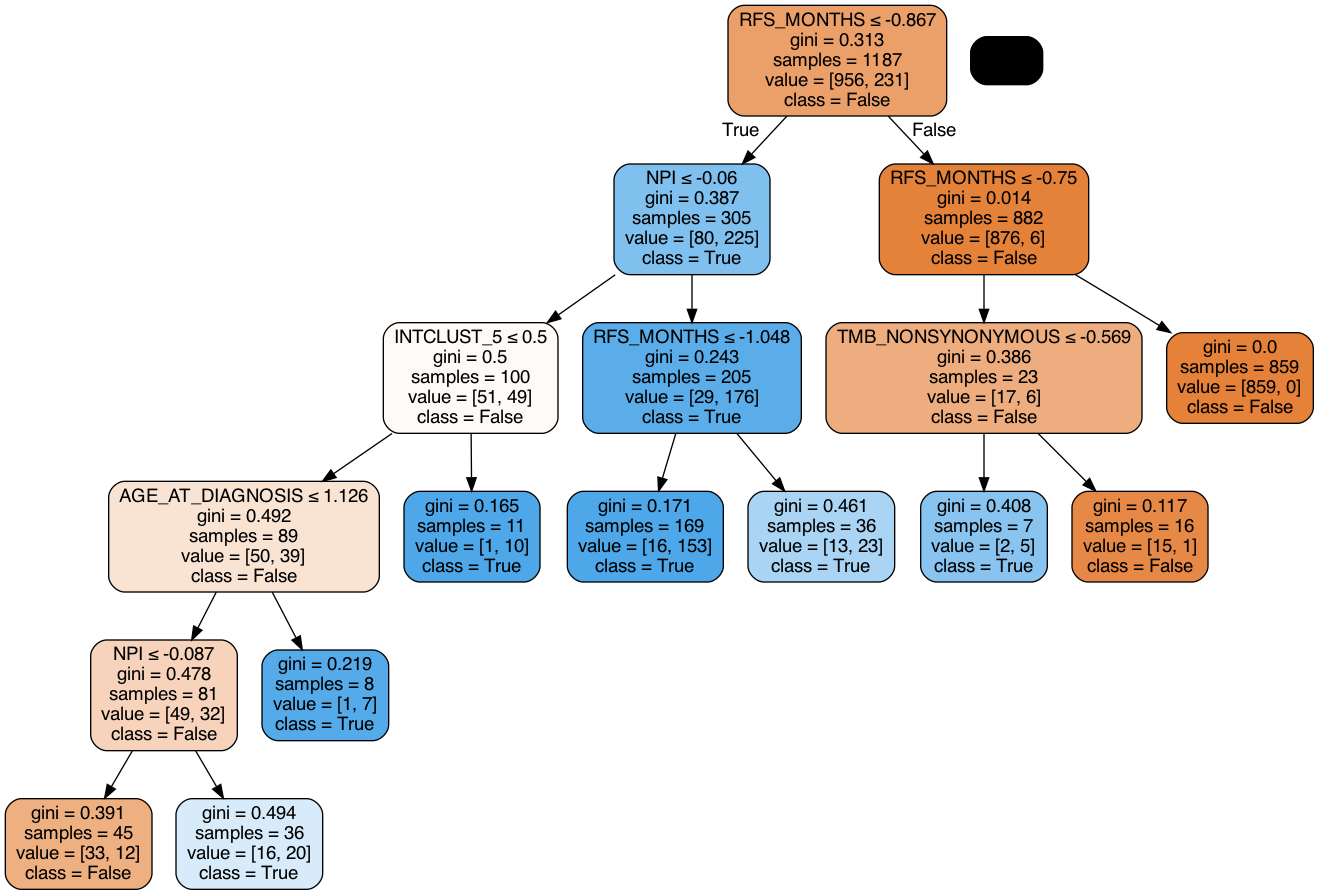

In [20]:
%matplotlib inline
dot_data = StringIO()  # dotファイル情報の格納先
export_graphviz(
    clf_tree,
    out_file=dot_data,
    feature_names=X_train_std.columns,
    class_names=["False", "True"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# graph.write_png(config.TREE_DIR + "/3.0.0-importance_dt.png")

"""
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 10))
plot_tree(
    clf_tree,
    feature_names=X.columns,
    class_names=True,
    label="all",
    filled=True,
    impurity=True,
    node_ids=True,
    proportion=True,
    rounded=True,
)
plt.show()
"""
Image(graph.create_png())

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [21]:
sm = SMOTE(random_state=SEED)
X_training, X_val, y_training, y_val = train_test_split(X_train_std, y_train)
X_resampled, y_resampled = sm.fit_resample(X_training, y_training)
y_resampled.value_counts()

False    721
True     721
Name: target_OS_5years, dtype: int64

'\n# 決定木の分類例表示（2変数の分類）\nclf = DecisionTreeClassifier()\nsns_separator_plot(\n    clf=clf,\n    x_columns=plot_columns,\n    y_column="target_OS_5years",\n    data=df_tmp,\n    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR\n    + "/sample_SMOTE.png",\n)\n'

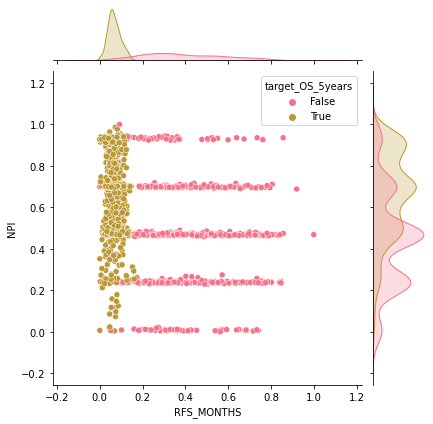

In [22]:
df_tmp = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR
    + "/SMOTE_scatter("
    + plot_columns[0]
    + " x "
    + plot_columns[1]
    + ").png"
)

# SMOTE実施後の分布のプロット
sns_join_plot(
    X=X_resampled,
    y=y_resampled,
    plot_columns=plot_columns,
    save_path=save_path,
)
"""
# 決定木の分類例表示（2変数の分類）
clf = DecisionTreeClassifier()
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns,
    y_column="target_OS_5years",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_SMOTE.png",
)
"""

In [23]:
# オーバーサンプリングありのモデル比較
display(
    compare_bcms(
        X=X_train_std,
        y=y_train,
        over_sampling_class=SMOTE(random_state=SEED),
        bcm_names=bcm_names,
        classifiers=classifiers,
    )
)

"""
plot_bcm_border(
    X=X,
    y=y,
    over_sampling_class=SMOTE(random_state=SEED),
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR,
)
"""

Logistic Regression


5it [00:00,  6.74it/s]


Nearest Neighbors


5it [00:00, 32.66it/s]


Linear SVM


5it [01:06, 13.29s/it]


Polynomial SVM


5it [00:00,  5.44it/s]


RBF SVM


5it [00:01,  2.64it/s]


Sigmoid SVM


5it [00:00,  7.37it/s]


Decision Tree


5it [00:00, 67.17it/s]


Random Forest


5it [00:00,  7.17it/s]


AdaBoost


5it [00:00,  8.38it/s]


Naive Bayes


5it [00:00, 95.43it/s]


Quadratic Discriminant Analysis


5it [00:00, 44.74it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.940198,1.000000,0.852322
Linear SVM,0.965746,0.927564,0.966096,0.823872
AdaBoost,0.975027,0.924178,0.975299,0.815359
Logistic Regression,0.963391,0.920824,0.963770,0.804673
Decision Tree,1.000000,0.916601,1.000000,0.785961
Quadratic Discriminant Analysis,0.920914,0.850048,0.925554,0.672235
Naive Bayes,0.918028,0.872783,0.916095,0.638877
Nearest Neighbors,0.827154,0.603964,0.835645,0.311837
Sigmoid SVM,0.493083,0.492011,0.493723,0.287379


'\nplot_bcm_border(\n    X=X,\n    y=y,\n    over_sampling_class=SMOTE(random_state=SEED),\n    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR,\n)\n'

In [25]:
# オーバーサンプリングあり、正規化ありのモデル比較
display(
    compare_bcms(
        X=X_train_std,
        y=y_train,
        over_sampling_class=SMOTE(random_state=SEED),
        bcm_names=bcm_names,
        classifiers=classifiers,
        normalization=True,
    )
)

"""
plot_bcm_border(
    X=X,
    y=y,
    over_sampling_class=SMOTE(random_state=SEED),
    normalization=True,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_NORMALIZATION_DIR,
)
"""

Logistic Regression


5it [00:01,  4.71it/s]


Nearest Neighbors


5it [00:00, 11.67it/s]


Linear SVM


5it [00:45,  9.09s/it]


Polynomial SVM


5it [00:01,  4.37it/s]


RBF SVM


5it [00:02,  2.44it/s]


Sigmoid SVM


5it [00:00,  5.22it/s]


Decision Tree


5it [00:00, 14.47it/s]


Random Forest


5it [00:00,  5.08it/s]


AdaBoost


5it [00:00,  6.15it/s]


Naive Bayes


5it [00:00, 15.12it/s]


Quadratic Discriminant Analysis


5it [00:00, 13.40it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.934301,1.000000,0.835300
Linear SVM,0.966792,0.923338,0.967095,0.812544
Logistic Regression,0.963524,0.923352,0.963934,0.810028
AdaBoost,0.976338,0.919126,0.976593,0.803991
Decision Tree,1.000000,0.914920,1.000000,0.783028
Quadratic Discriminant Analysis,0.921176,0.850888,0.925809,0.673260
Naive Bayes,0.918029,0.871939,0.916094,0.635932
Nearest Neighbors,0.808075,0.598085,0.818522,0.315744
Sigmoid SVM,0.493083,0.492011,0.493723,0.287379


'\nplot_bcm_border(\n    X=X,\n    y=y,\n    over_sampling_class=SMOTE(random_state=SEED),\n    normalization=True,\n    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_NORMALIZATION_DIR,\n)\n'